In [195]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import warnings
import numpy as np

warnings.filterwarnings(action='ignore')

data = pd.read_csv('Updated wOBA data.csv')
X = data.drop(['Name', 'Team', 'playerid', 'wOBA', 'SLG', 'OBP', 'PA'], axis=1)
y = data['wOBA']

model = XGBRegressor(learning_rate=0.1, n_estimators=1000, max_depth=3, subsample=0.8)
model.fit(X, y)

var_importances = pd.DataFrame({'Variable': X.columns, 'Importance': model.feature_importances_}).sort_values('Importance', ascending=False)
var_importances['Importance'] =  var_importances['Importance']

print(var_importances)

      Variable  Importance
15    HardHit%    0.217346
16     Barrel%    0.210425
11        BB/K    0.108011
10        CSW%    0.060098
13          K%    0.051374
17          EV    0.047518
7    F-Strike%    0.035528
12         BB%    0.034530
6        Zone%    0.027669
14      Clutch    0.027413
3   O-Contact%    0.023976
1     Z-Swing%    0.023530
8       SwStr%    0.020753
18          LA    0.020194
4   Z-Contact%    0.020004
2       Swing%    0.019695
5     Contact%    0.017705
9        CStr%    0.017704
0     O-Swing%    0.016527


In [196]:
top_features = ['Barrel%', 'EV', 'CSW%', 'BB/K', 'HardHit%', 'CSW%', 'K%']
new_X = X[top_features]

model2 = DecisionTreeRegressor(random_state=1)
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=0)
model2.fit(train_X, train_y)

predictions = model2.predict(test_X)

max_wOBA = round(max(predictions), 3)
min_wOBA = round(min(predictions), 3)

print("Max predicted wOBA: ", max_wOBA)
print("Min predicted wOBA: ", min_wOBA)


Max predicted wOBA:  0.38
Min predicted wOBA:  0.26


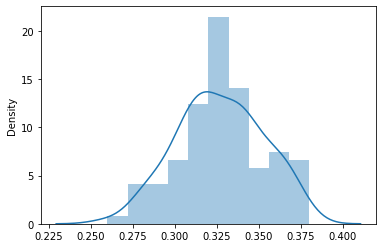

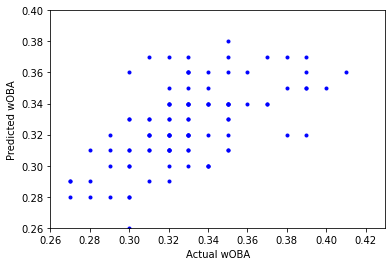

In [197]:
mae = mean_absolute_error(test_y, predictions)

sns.distplot(predictions)

plt.figure(2)
plt.plot(test_y, predictions, 'b.')
plt.xlabel('Actual wOBA')
plt.ylabel('Predicted wOBA')
plt.axis([min_wOBA, max_wOBA+.05, min_wOBA, max_wOBA+0.02])
plt.show()
